In [1]:
# Copy from kaggle
import kagglehub

# Download latest version
org_path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", org_path)


Path to dataset files: C:\Users\CindyHong\.cache\kagglehub\datasets\lantian773030\pokemonclassification\versions\1


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import ImageOps,ImageEnhance
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split
import scipy

from torchvision import models
from sklearn.utils.class_weight import compute_class_weight



In [3]:
np.random.seed(2024)

In [4]:
# Setting dataset path
path = os.path.join(org_path,'PokemonData')
path

'C:\\Users\\CindyHong\\.cache\\kagglehub\\datasets\\lantian773030\\pokemonclassification\\versions\\1\\PokemonData'

In [5]:
class_list = pd.read_csv('class_sheet.csv')

In [6]:
bad_class_list = class_list[class_list['Bad_Data'] == 1]['Pokemon']
bad_image_paths = []
valid_extensions = ['.jpg', '.jpeg', '.png']

In [7]:
# Removing all classes with bad data
class_list = class_list[class_list['Bad_Data'] != 1]

In [8]:
# Getting Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [49]:
# Making a data frame that has the image arrays and their classifcation
image_paths = []
wrong_extensions = []

for folder in winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        if not os.path.exists(image_path):
            print(image_path)
            continue
        image_paths.append({'File_Path': image_path, 'Source': 'Winged'})
           
for folder in not_winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        if not os.path.exists(image_path):
            print(image_path)
            continue
        image_paths.append({'File_Path': image_path, 'Source': 'Not Winged'})
            
df = pd.DataFrame(image_paths)
set(wrong_extensions)

{'.asp',
 ".jpg')",
 '.jpg~c200',
 '.sb-334870d9-FK2TVI',
 '.sb-334870d9-nlD60H',
 '.svg'}

In [50]:
df['y'] = (df['Source'] == 'Winged').astype(int)

In [51]:
# Making a 80/10/10 Train/Valid/Test sets
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['y'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['y'], random_state=42)

In [52]:
#train_df.to_csv('train.csv')
#val_df.to_csv('validate.csv')
#test_df.to_csv('test.csv')

In [67]:
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        self.transform = transform = transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['File_Path']
        label = self.data.iloc[idx]['y']
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        return image, label

In [68]:
train_dataset = ImageDataset(dataframe=train_df)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

In [69]:
val_dataset = ImageDataset(dataframe=val_df)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)

In [70]:
test_dataset = ImageDataset(dataframe=test_df)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [76]:
# device='cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification (0 and 1)
model = model.to(device)

C:\Users\CindyHong\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CindyHong\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
labels = train_df['y'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

In [79]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [80]:
def calculate_accuracy(loader, model, device):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [82]:
num_epochs = 25
best_val_accuracy = 0
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()        
        optimizer.zero_grad()        
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()
    
    train_accuracy = calculate_accuracy(train_loader, model, device)
    val_accuracy = calculate_accuracy(val_loader, model, device)
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Accuracy: {val_accuracy:.2f}%")
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model9.pth')

Epoch [1/25], Loss: 0.3021, Train Accuracy: 93.39%, Test Accuracy: 91.20%
Epoch [2/25], Loss: 0.2355, Train Accuracy: 84.65%, Test Accuracy: 81.56%
Epoch [3/25], Loss: 0.2180, Train Accuracy: 96.74%, Test Accuracy: 94.68%
Epoch [4/25], Loss: 0.1483, Train Accuracy: 94.10%, Test Accuracy: 91.53%
Epoch [5/25], Loss: 0.1325, Train Accuracy: 98.96%, Test Accuracy: 96.51%
Epoch [6/25], Loss: 0.0948, Train Accuracy: 93.04%, Test Accuracy: 91.36%
Epoch [7/25], Loss: 0.1822, Train Accuracy: 91.50%, Test Accuracy: 88.87%
Epoch [8/25], Loss: 0.0636, Train Accuracy: 99.34%, Test Accuracy: 97.18%
Epoch [9/25], Loss: 0.0951, Train Accuracy: 97.90%, Test Accuracy: 94.85%
Epoch [10/25], Loss: 0.0613, Train Accuracy: 98.05%, Test Accuracy: 92.86%
Epoch [11/25], Loss: 0.0692, Train Accuracy: 97.38%, Test Accuracy: 94.02%
Epoch [12/25], Loss: 0.0685, Train Accuracy: 92.08%, Test Accuracy: 89.70%
Epoch [13/25], Loss: 0.0826, Train Accuracy: 85.25%, Test Accuracy: 80.73%
Epoch [14/25], Loss: 0.0460, Train

In [84]:
model.load_state_dict (torch.load('best_model9.pth'))
print(calculate_accuracy(train_loader, model, device))
print(calculate_accuracy(val_loader, model, device))
print(calculate_accuracy(test_loader, model, device))

C:\Users\CindyHong\AppData\Local\Temp\ipykernel_16540\594932186.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict (torch.load('best_model9.pth'))


99.93766881362976
97.50830564784053
95.51495016611295


In [91]:
def calculate_accuracy(loader, model, device):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def get_losses(losses,loader, model, device):
    loss = 0.0
    model.eval() 
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            l = criterion(outputs, targets)
            loss += l.item()
    loss /= len(loader)
    losses.append(loss)
    return losses

def get_predictions(loader, model, device):
    all_targets = []
    all_predictions = []
    model.eval() 
    # for epoch in range(epoches):
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    return all_targets,all_predictions

# Plot loss curve and confusion matrix for NNs
def loss_curve(epoches,train_losses,val_losses):
    # loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoches + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epoches + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Curve')
    plt.legend()
    plt.show()

def plot_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions):

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    # calculate confusion matrix
    cm = confusion_matrix(all_train_targets, all_train_predictions)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Train')
    
    plt.subplot(1, 3, 2)
    # calculate confusion matrix
    cm = confusion_matrix(all_val_targets, all_val_predictions)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Val')
    
    
    plt.subplot(1, 3, 3)
    # calculate confusion matrix
    cm = confusion_matrix(all_test_targets, all_test_predictions)
    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test')
    plt.show()
    
def print_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions):
    print(classification_report(all_train_targets,all_train_predictions))
    print(classification_report(all_val_targets,all_val_predictions))
    print(classification_report(all_test_targets,all_test_predictions))
    

In [93]:
# evaluate model

all_train_targets = []
all_train_predictions = []

all_train_targets,all_train_predictions = get_predictions(train_loader, model, device)

all_val_targets = []
all_val_predictions = []

all_val_targets,all_val_predictions = get_predictions(val_loader, model, device)

all_test_targets = []
all_test_predictions = []

all_test_targets,all_test_predictions = get_predictions(test_loader, model, device)




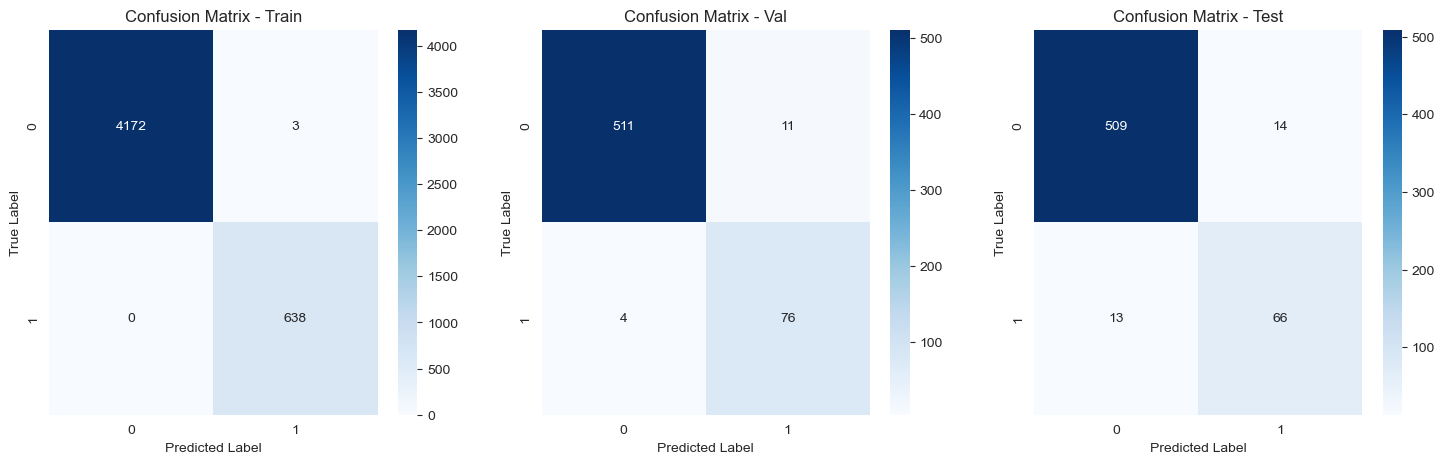

In [92]:
plot_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions)

In [90]:
print_confusion_matrix(all_train_targets,all_train_predictions,all_val_targets,all_val_predictions,all_test_targets,all_test_predictions)

torch.cuda.empty_cache()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4175
           1       1.00      1.00      1.00       638

    accuracy                           1.00      4813
   macro avg       1.00      1.00      1.00      4813
weighted avg       1.00      1.00      1.00      4813

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       522
           1       0.87      0.95      0.91        80

    accuracy                           0.98       602
   macro avg       0.93      0.96      0.95       602
weighted avg       0.98      0.98      0.98       602

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       523
           1       0.82      0.84      0.83        79

    accuracy                           0.96       602
   macro avg       0.90      0.90      0.90       602
weighted avg       0.96      0.96      0.96       602

